In [13]:
# Required Modules

import talib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)

# Custom Functions

In [3]:
def plot(y_train, y_test, y_train_pred, y_test_pred, timestamp, train_size):
    plt.plot(timestamp[:train_size], y_train, label="training(actual)")
    plt.plot(timestamp[train_size:], y_test, label="testing(actual)")
    plt.plot(timestamp[:train_size], y_train_pred, label="training(forecast)")
    plt.plot(timestamp[train_size:], y_test_pred, label="testing(forecast)")
    plt.legend()
    
    return

# Loading and preprocessing data
The company which I have choosen is sbi, as I am only interested in Adj Closing price and Volume traded
I will load that into another data frame

In [5]:
data = pd.read_csv('SBI_2005-01-01_2020-04-15.csv', index_col='Date')
data.index = pd.to_datetime(data.index)
data['Percent change'] = data[['Adj Close']].pct_change()
data.dropna(inplace=True)
data['Direction'] = np.where(data['Percent change'] > 0, 1, 0)
print(data.head())
print()

sbi = data[['Adj Close', 'Volume', 'Direction']]
sbi.columns = ['Adj_Close', 'Volume', 'Direction']
print(sbi.head())

            Open  High   Low  Close  Adj Close  Volume  Percent change  \
Date                                                                     
2005-01-03  9.36  9.46  9.36   9.46   4.564371   10200        0.010684   
2005-01-04  9.49  9.60  9.45   9.50   4.583670   20300        0.004228   
2005-01-05  9.50  9.54  9.41   9.54   4.602970   14000        0.004210   
2005-01-06  9.44  9.59  9.41   9.50   4.583670   11300       -0.004193   
2005-01-07  9.58  9.65  9.54   9.60   4.631922   17400        0.010527   

            Direction  
Date                   
2005-01-03          1  
2005-01-04          1  
2005-01-05          1  
2005-01-06          0  
2005-01-07          1  

            Adj_Close  Volume  Direction
Date                                    
2005-01-03   4.564371   10200          1
2005-01-04   4.583670   20300          1
2005-01-05   4.602970   14000          1
2005-01-06   4.583670   11300          0
2005-01-07   4.631922   17400          1


# Exploratory Data Analysis
Showing the line plot and Histogram of the data

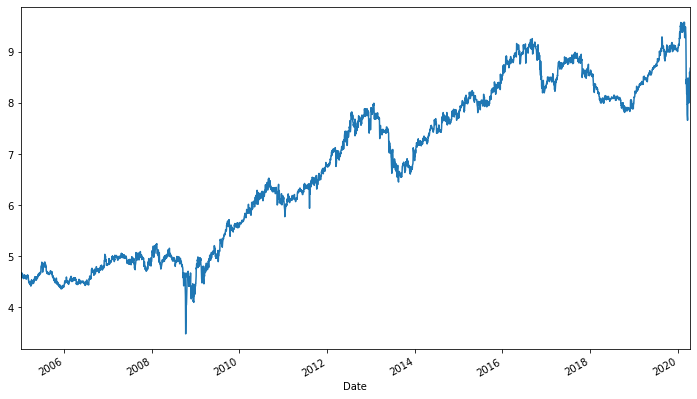

In [6]:
sbi['Adj_Close'].plot()

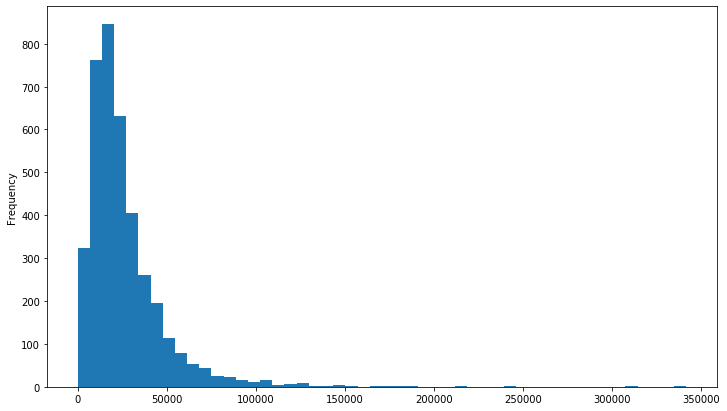

In [7]:
sbi['Volume'].plot.hist(bins=50)

# Expanding Feature Space

Indicators which I have selected are
* Relative Strength Index(RSI)
* Simple Moving Average(SMA)
* Rate Of Change Price(ROCP)

and calculated over the rolling windows of 7, 14, 30, 60

In [8]:
indicators = ['SMA', 'RSI', 'ROCP']
rolling_windows = [7, 14, 30, 60]
targets = ['Direction']
features = ['Volume']

for n in rolling_windows:
    for ind in indicators:
        col_name = "Adj_Close_"+ind+"_"+str(n)
        features.append(col_name)
        if ind == 'SMA':
            sbi[col_name] = talib.SMA(sbi['Adj_Close'], timeperiod=n)
        elif ind == 'RSI':
            sbi[col_name] = talib.RSI(sbi['Adj_Close'], timeperiod=n)
        elif ind == 'ROCP':
            sbi[col_name] = talib.ROCP(sbi['Adj_Close'], timeperiod=n)
sbi = sbi.dropna()
timestamp = sbi.index

features_length = len(features)
targets_length = len(targets)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

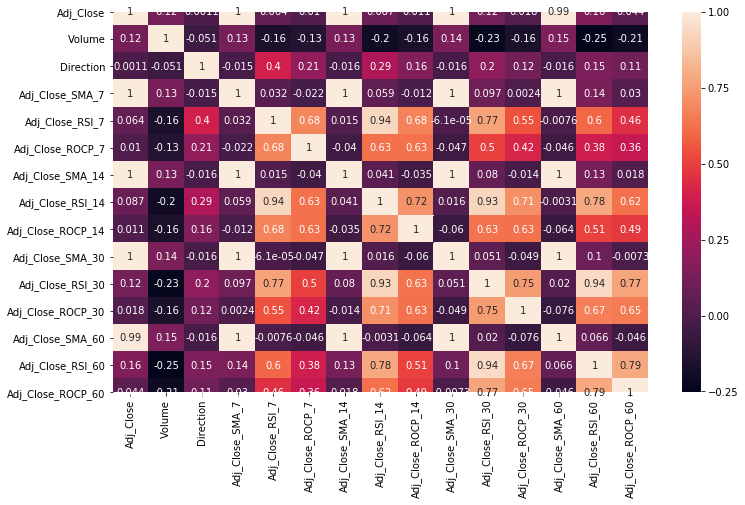

In [9]:
# Correlation Heatmap

sns.heatmap(sbi.corr(), annot=True)

# Train Test Split

Dividing the entire data into training and testing sets, with testing size of 0.25

In [10]:
length = len(sbi)
train_ratio = 0.75
train_size = int(train_ratio * length)

X_train = sbi[features][:train_size]
y_train = sbi[targets][:train_size]
X_test = sbi[features][train_size:]
y_test = sbi[targets][train_size:]

# Logistic Regression

In [11]:
reg = LogisticRegression()
reg.fit(X_train.values, y_train.values)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
y_train_pred = reg.predict(X_train.values)
y_test_pred = reg.predict(X_test.values)

confusion_mat = confusion_matrix(y_test_pred, y_test.values)
accuracy = (confusion_mat[0][0]+confusion_mat[1][1])/np.sum(confusion_mat)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_mat)
print("Classification report:\n", classification_report(y_test_pred, y_test.values))

Accuracy: 0.7022175290390708
Confusion Matrix:
 [[402 173]
 [109 263]]
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.70      0.74       575
           1       0.60      0.71      0.65       372

    accuracy                           0.70       947
   macro avg       0.69      0.70      0.70       947
weighted avg       0.71      0.70      0.71       947

